**Level-2: Improved Generalization via Data Augmentation**

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 4
SEED = 42
EPOCHS = 8

torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Data Augmentation**

In [ ]:
# to improve generalization and reduce overfitting
train_transform = transforms.Compose([
    transforms.RandomCrop(128, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


**Dataset Preparation**

In [ ]:
full_train_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=eval_transform
)


100%|██████████| 170M/170M [00:02<00:00, 77.2MB/s]


**Train / Validation Split**

In [ ]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

val_dataset.dataset.transform = eval_transform


**Data Loading Pipeline**

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Fine-tuned ResNet-18 Architecture**

In [ ]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader, leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


**Training**

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Epoch [1/8] | Train Loss: 0.5120, Train Acc: 0.8277 | Val Loss: 0.4413, Val Acc: 0.8465


Epoch [2/8] | Train Loss: 0.2728, Train Acc: 0.9079 | Val Loss: 0.4033, Val Acc: 0.8638


Epoch [3/8] | Train Loss: 0.1617, Train Acc: 0.9453 | Val Loss: 0.4051, Val Acc: 0.8705


Epoch [4/8] | Train Loss: 0.0893, Train Acc: 0.9697 | Val Loss: 0.3276, Val Acc: 0.9000


Epoch [5/8] | Train Loss: 0.0347, Train Acc: 0.9883 | Val Loss: 0.2977, Val Acc: 0.9160


Epoch [6/8] | Train Loss: 0.0098, Train Acc: 0.9972 | Val Loss: 0.2587, Val Acc: 0.9328


Epoch [7/8] | Train Loss: 0.0020, Train Acc: 0.9998 | Val Loss: 0.2406, Val Acc: 0.9387


Epoch [8/8] | Train Loss: 0.0009, Train Acc: 0.9999 | Val Loss: 0.2405, Val Acc: 0.9380


**Final Evaluation**

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Accuracy (Level-2): {test_acc:.4f}")


Final Test Accuracy (Level-2): 0.9308


**Training Visualization**

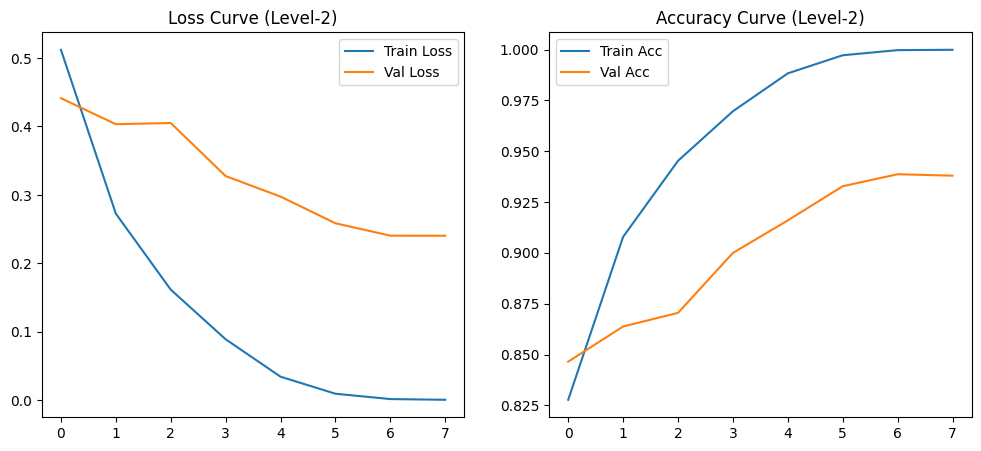

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve (Level-2)")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve (Level-2)")

plt.show()
